## Kolmogorov-Smirnov test    
by Tonatiuh Rangel

## Contents:    
1. [Theory](#theory)   
2. [Numerical example](#example)
3. [Scipy's example](#scipy)


<a id='theory'></a>
Also called "Kolmogorov-Smirnov goodness of fit test".   
This is used to test if two samples are drawn from different distributions.    


### Hypothesis    
**Null hypothesis**: the two samples come from the same distribution    
**Alternative hypothesis**: the two samples are drawn from different distributions      

### Test statistic    
The test statistic is computed as the maximum distance between the corresponding two cumulative distribution functions (CDF) for the two samples.    

### P-value    
P-value is obtained from tables for the two-sided KS test. 
Here, I use the scikit-learn's cumulative distribution function of Kolmogorov's distribution.


In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.figsize": (6, 4)})
sns.set_context('talk')

from scipy.stats import ks_2samp, kstwobign 
from scipy.interpolate import interp1d

In [2]:
def get_cdfs(X, Y):
    """
    Get CDF functions for X, Y
    
    Arguments
    X, numpy array
    Y, numpy array
    
    Returns
    CDF_X(x), function 
    CDF_Y(x), function
    """
    n1 = len(X)
    n2 = len(Y)
    data1 = np.sort(X)
    data2 = np.sort(Y)
    data_all = np.concatenate([data1,data2])
    cdf1 = np.searchsorted(data1,data_all,side='right')/(1.0*n1)
    cdf2 = (np.searchsorted(data2,data_all,side='right'))/(1.0*n2)
 
    # Now that we have computed CDF_X and CDF_Y for discrete set of values, we need to make them continuous functions
    def CDF_X(x):
        ff = interp1d(data_all, cdf1, kind='slinear')
        return ff(x)
    def CDF_Y(x):
        ff = interp1d(data_all, cdf2, kind='slinear')
        return ff(x) 
    return CDF_X, CDF_Y


def apply_kolmogorov_test(n1, n2, CDF1, CDF2):
    
    # Evaluate CDF functions for a discrete number of samples and get maximum diff:   
    x = np.linspace(max(np.min(X), np.min(Y)), min(np.max(X), np.max(Y)), 10000)
    
    # Get the maximum distance between the two distributions:
    diff = np.abs(CDF1(x) - CDF2(x))
    KS_statistic = diff.max()
    # Get the index for the max. between the two distributions, for plotting
    KS_index = x[diff.argmax()]
    
    # Pvalue from https://github.com/scipy/scipy/blob/v0.19.0/scipy/stats/stats.py
    en = np.sqrt(n1 * n2 / float(n1 + n2))
    try:
        pvalue = kstwobign.sf((en + 0.12 + 0.11 / en) * KS_statistic)
    except:
        pvalue = 1.0
    
    return KS_statistic, pvalue,  KS_index

def plot_distributions(X, Y):
    fig, ax = plt.subplots(1)
    
    sns.distplot(X, label='X', ax=ax)
    sns.distplot(Y, label='Y', ax=ax)
    ax.set_xlabel('Sepal length (cm)')
    ax.legend(loc=0)
    sns.despine()

def plot_kolmogorov_test(x, CDF_X, CDF_Y, KS_index):

    fig, ax = plt.subplots()
    
    ax.plot(x, CDF_X(x), color='blue', linestyle='-', lw=5, alpha=0.6, label = 'X' )
    ax.plot(x, CDF_Y(x), color='orange', linestyle='-', lw=5, alpha=0.6, label = 'Y')

    ax.plot([KS_index, KS_index], [CDF_X(KS_index), CDF_Y(KS_index)], color='k', linestyle='-', linewidth=2)
    
    ax.text(KS_index + np.max(x) / 200 , 0.5, 'KS statistic',color='k')
    ax.legend(loc=0)
    ax.set_ylabel('CDF')
    ax.set_xlabel('Sepal length (cm)')

    sns.despine()

<a id='example'></a>    
## Numerical example    
Let's use the KS-test to tell whether two samples come from the same distribution.    
In this example, I test data from the *iris dataset*, which contains samples for different iris species.    


In [3]:
# import some data to play with
iris = datasets.load_iris()

df = pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


Sample X of size 50 and sample Y of size 50


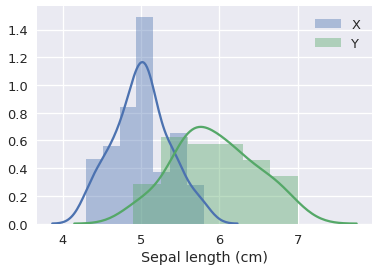

In [4]:
# Get samples of sepal lenth for two different species
X = df[df.target == 0]['sepal length (cm)'].values
Y = df[df.target == 1]['sepal length (cm)'].values

# Its a good idea to remove outliers
#X = X[np.where((X > np.percentile(X, 1)) & (X < np.percentile(X, 99)))]
#Y = Y[np.where((Y > np.percentile(Y, 1)) & (Y < np.percentile(Y, 99)))]

print('Sample X of size {} and sample Y of size {}'.format(len(X), len(Y)))
# Lets visualize the sample distributions
plot_distributions(X, Y)

### Compute KS statistic and p-value    

KS_statistic 0.78, p-value 2.1317578632654785e-14


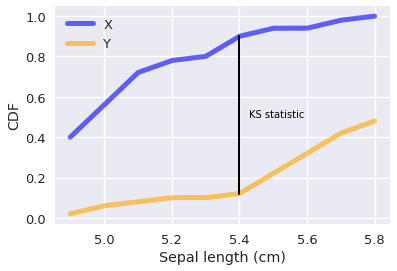

In [5]:
# I get cumulative distribution functions
CDF_X, CDF_Y = get_cdfs(X, Y)

# Now find the maximum difference between the two CDF
KS_statistic, pvalue, KS_index = apply_kolmogorov_test(len(X), len(Y), CDF_X, CDF_Y)
print('KS_statistic {}, p-value {}'.format(KS_statistic, pvalue))

# Plot the CDFs and KS statistic
# Evaluate CDF functions for a discrete number of samples  
x = np.linspace(max(np.min(X), np.min(Y)), min(np.max(X), np.max(Y)), 10000)

plot_kolmogorov_test(x, CDF_X, CDF_Y, KS_index)

In the figure above, we can see the two CDFs and the KS statistic corresponding to the maximum distance between the two CDFs.    
The p-value for the KS statistic of 0.78 is virtually zero, hence we reject the null hypothesis that both samples are drawn from the same distribution.


<a id='scipy'></a>   
## Scipy    
Now let's repeat the test using the scipy's implementation    

In [6]:
ks_2samp(X, Y)

Ks_2sampResult(statistic=0.78, pvalue=2.1317578632654785e-14)